In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
plt.style.use('seaborn')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

from cicyutils import CicyPad, StratifiedSampler
from cicyutils import pretty_print_results, analyze_knn_cv

# sklearn throws a warning when doing GridSearchCV due to some classes being
# sparsely populated. ignore this.

import warnings
warnings.filterwarnings('ignore')                                   

In [2]:
# Load the dataset and select only the matrix entries and h11, h21 entries
df_cicy=pd.read_hdf('cicydata/cicy3f.h5')
# the Hodge number being classified on
h='h11'
upsampled_w, upsampled_h = 18, 18

# K Nearest Neighbors Classifier

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, matthews_corrcoef

## Standard Train/test Split

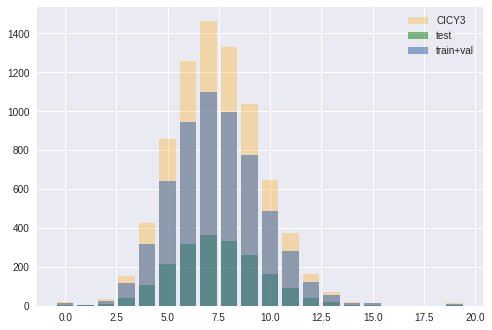

+-----+--------------------+-------------------+--------------+----------------+
|   h |   train population |   test population |   train+test |   h population |
+=====+====================+===================+==============+================+
|   0 |                 16 |                 6 |           22 |             22 |
+-----+--------------------+-------------------+--------------+----------------+
|   1 |                  3 |                 2 |            5 |              5 |
+-----+--------------------+-------------------+--------------+----------------+
|   2 |                 27 |                 9 |           36 |             36 |
+-----+--------------------+-------------------+--------------+----------------+
|   3 |                116 |                39 |          155 |            155 |
+-----+--------------------+-------------------+--------------+----------------+
|   4 |                318 |               107 |          425 |            425 |
+-----+--------------------+

In [4]:
min_sample, ratio = 1,0.75
traintest = StratifiedSampler(df_cicy,h,min_sample,ratio)
x_train, x_test = traintest.stratified_split(['matrix'])
traintest.plot_population()
traintest.pretty_print()
x_train, x_test, y_train, y_test = x_train['matrix'], x_test['matrix'], x_train[h], x_test[h]

### Tuning hyperparameters using Grid Search and Cross-Validation

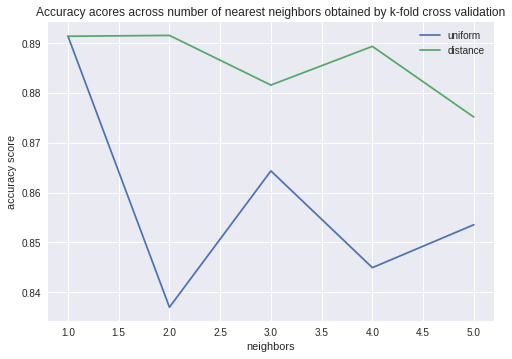

best parameters: {'knn Classifier__n_neighbors': 2, 'knn Classifier__weights': 'distance'}


In [5]:
knn_pipeline = Pipeline([("array padding", CicyPad(upsampled_w=upsampled_w,
                                                   upsampled_h=upsampled_h,
                                                   ravel=True)),
                         ("standard scaler", StandardScaler()),
                         ("knn Classifier", KNeighborsClassifier())])

param_grid = [{'knn Classifier__n_neighbors':list(range(1,6)), 
               'knn Classifier__weights': ['uniform', 'distance']}]

grid_search = GridSearchCV(knn_pipeline,param_grid,cv=5)

grid_search.fit(x_train,y_train)

cross_val_results = grid_search.cv_results_

analyze_knn_cv(cross_val_results)

print('best parameters:', grid_search.best_params_)

### ROC Curve

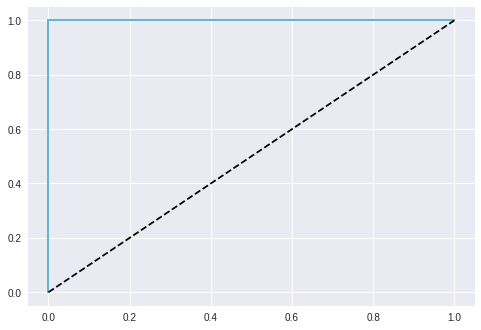

In [6]:
n_neighbors = grid_search.best_params_['knn Classifier__n_neighbors']
weights = grid_search.best_params_['knn Classifier__weights']

knn_pipeline_best = Pipeline([("array padding", CicyPad(upsampled_w=18,upsampled_h=18,ravel=True)),
                         ("standard scaler", StandardScaler()),
                         ("knn Classifier", KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights))])
knn_pipeline_best.fit(x_train,y_train)
y_proba = knn_pipeline_best.predict_proba(x_train)


fpr_list, tpr_list, threshold_list = [],[],[]

for i,y in enumerate(np.unique(y_train)):
    y_scores = y_proba[:,i] # see Pg 99 of Geron
    fpr,tpr,thresholds = roc_curve((y_train==y).astype(int),y_scores)
    plt.plot(fpr,tpr,linewidth=2)

plt.plot([0,1],[0,1],'k--')
plt.show()

### Fitting on to Test set

In [7]:
y_pred = knn_pipeline_best.predict(x_test)
print('accuracy score:', accuracy_score(y_test,y_pred))
print('matthews correlation coefficient:',matthews_corrcoef(y_test,y_pred))

accuracy score: 0.9089989888776542
matthews correlation coefficient: 0.8953984413255995


In [8]:
pretty_print_results(y_test,y_pred)

+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   h |   test population |   predicted |   true positives |   precision |   recall |   percentage of test set isolated |
+=====+===================+=============+==================+=============+==========+===================================+
|   0 |                 6 |           4 |                3 |        0.75 |     0.5  |                              0.2  |
+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   1 |                 2 |           0 |                0 |      nan    |     0    |                              0    |
+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   2 |                 9 |           8 |                6 |        0.75 |     0.67 |                              0.4  |
+-----+-----------------

## Few-Shot Split

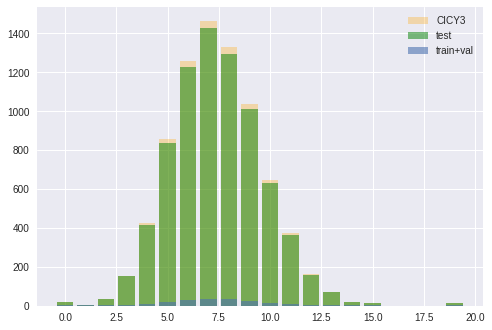

+-----+--------------------+-------------------+--------------+----------------+
|   h |   train population |   test population |   train+test |   h population |
+=====+====================+===================+==============+================+
|   0 |                  3 |                19 |           22 |             22 |
+-----+--------------------+-------------------+--------------+----------------+
|   1 |                  3 |                 2 |            5 |              5 |
+-----+--------------------+-------------------+--------------+----------------+
|   2 |                  3 |                33 |           36 |             36 |
+-----+--------------------+-------------------+--------------+----------------+
|   3 |                  3 |               152 |          155 |            155 |
+-----+--------------------+-------------------+--------------+----------------+
|   4 |                 10 |               415 |          425 |            425 |
+-----+--------------------+

In [9]:
min_sample, ratio = 3,0.025
traintest = StratifiedSampler(df_cicy,h,min_sample,ratio)
x_train, x_test = traintest.stratified_split(['matrix'])
traintest.plot_population()
traintest.pretty_print()
x_train, x_test, y_train, y_test = x_train['matrix'], x_test['matrix'], x_train[h], x_test[h]

### Tuning hyperparameters using Grid Search and Cross-Validation

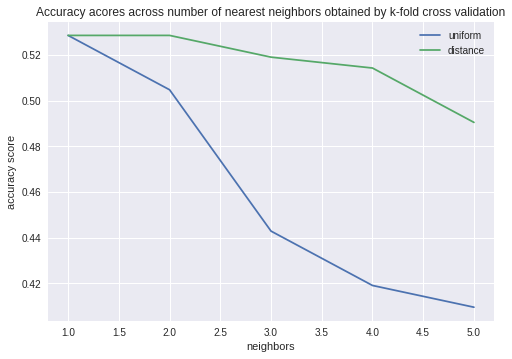

best parameters: {'knn Classifier__n_neighbors': 1, 'knn Classifier__weights': 'uniform'}


In [10]:
knn_pipeline = Pipeline([("array padding", CicyPad(upsampled_w=upsampled_w,
                                                   upsampled_h=upsampled_h,
                                                   ravel=True)),
                         ("standard scaler", StandardScaler()),
                         ("knn Classifier", KNeighborsClassifier())])

param_grid = [{'knn Classifier__n_neighbors':list(range(1,6)), 
               'knn Classifier__weights': ['uniform', 'distance']}]

grid_search = GridSearchCV(knn_pipeline,param_grid,cv=5)

grid_search.fit(x_train,y_train)

cross_val_results = grid_search.cv_results_

analyze_knn_cv(cross_val_results)

print('best parameters:', grid_search.best_params_)

### ROC Curve

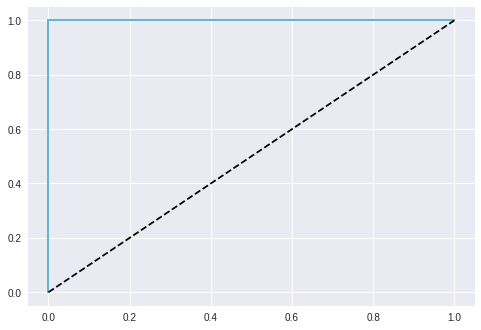

In [11]:
n_neighbors = grid_search.best_params_['knn Classifier__n_neighbors']
weights = grid_search.best_params_['knn Classifier__weights']

knn_pipeline_best = Pipeline([("array padding", CicyPad(upsampled_w=18,upsampled_h=18,ravel=True)),
                         ("standard scaler", StandardScaler()),
                         ("knn Classifier", KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights))])
knn_pipeline_best.fit(x_train,y_train)
y_proba = knn_pipeline_best.predict_proba(x_train)


fpr_list, tpr_list, threshold_list = [],[],[]

for i,y in enumerate(np.unique(y_train)):
    y_scores = y_proba[:,i] # see Pg 99 of Geron
    fpr,tpr,thresholds = roc_curve((y_train==y).astype(int),y_scores)
    plt.plot(fpr,tpr,linewidth=2)

plt.plot([0,1],[0,1],'k--')
plt.show()

### Fitting on to Test set

In [12]:
y_pred = knn_pipeline_best.predict(x_test)
print('accuracy score:', accuracy_score(y_test,y_pred))
print('matthews correlation coefficient:',matthews_corrcoef(y_test,y_pred))

accuracy score: 0.5619060018226794
matthews correlation coefficient: 0.4960732998926915


In [13]:
pretty_print_results(y_test,y_pred)

+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   h |   test population |   predicted |   true positives |   precision |   recall |   percentage of test set isolated |
+=====+===================+=============+==================+=============+==========+===================================+
|   0 |                19 |           9 |                5 |        0.56 |     0.26 |                              0.12 |
+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   1 |                 2 |           9 |                2 |        0.22 |     1    |                              0.12 |
+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   2 |                33 |          57 |               25 |        0.44 |     0.76 |                              0.74 |
+-----+-----------------

### A comparable model

The grid search results suggest that n_neighbors = 2 and weights ='distance' should perform comparably 

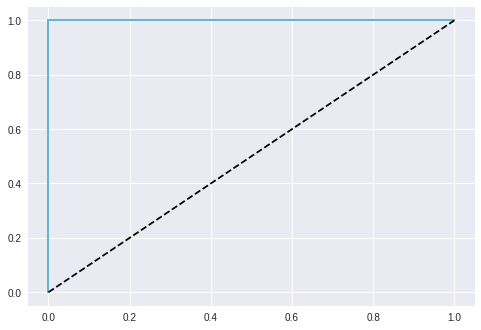

In [14]:
n_neighbors = 2
weights = 'distance'

knn_pipeline_best = Pipeline([("array padding", CicyPad(upsampled_w=18,upsampled_h=18,ravel=True)),
                         ("standard scaler", StandardScaler()),
                         ("knn Classifier", KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights))])
knn_pipeline_best.fit(x_train,y_train)
y_proba = knn_pipeline_best.predict_proba(x_train)


fpr_list, tpr_list, threshold_list = [],[],[]

for i,y in enumerate(np.unique(y_train)):
    y_scores = y_proba[:,i] # see Pg 99 of Geron
    fpr,tpr,thresholds = roc_curve((y_train==y).astype(int),y_scores)
    plt.plot(fpr,tpr,linewidth=2)

plt.plot([0,1],[0,1],'k--')
plt.show()

In [15]:
y_pred = knn_pipeline_best.predict(x_test)
print('accuracy score:', accuracy_score(y_test,y_pred))
print('matthews correlation coefficient:',matthews_corrcoef(y_test,y_pred))
pretty_print_results(y_test,y_pred)

accuracy score: 0.5619060018226794
matthews correlation coefficient: 0.4960732998926915
+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   h |   test population |   predicted |   true positives |   precision |   recall |   percentage of test set isolated |
+=====+===================+=============+==================+=============+==========+===================================+
|   0 |                19 |           9 |                5 |        0.56 |     0.26 |                              0.12 |
+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   1 |                 2 |           9 |                2 |        0.22 |     1    |                              0.12 |
+-----+-------------------+-------------+------------------+-------------+----------+-----------------------------------+
|   2 |                33 |          57 |               25